<div align="right"><i>Peter Norvig<br>12 August 2019</i></div>

# Tracking Trump: Electoral Votes Edition

Sites such as [RealClearPolitics](https://www.realclearpolitics.com/epolls/other/president_trump_job_approval-6179.html),  [538](https://projects.fivethirtyeight.com/trump-approval-ratings/), and [Mourning Consult](https://morningconsult.com/tracking-trump/) track presidential approval ratings (currently about 43% approval and 53% disapproval for a net -10%). Do approval ratings predict election results? There are three big caveats:

1. Today is not election day 2020. 

2. Approval polls are not votes. 

3. Popular votes are not electoral votes. 

We can't be conclusive about the first two points, but this notebook can use state-by-state approval polls to 
compute expected electoral votes, under the assumption that Trump wins the electoral votes of states he has positive net approval (and for the purposes of computation we'll count half the electoral votes for states where approval exactly equals disapproval).


# TL;DR for policy wonks

As of August 2019, Trump would expect  **172 electoral votes** under these assumptions (you need **270** to win). If you list states in order of his approval, the key turning-point state is Pennsylvania; he'd need to win that and every state in which he is more popular. He currently is **7% behind in Pennsylvania**; we call that the *margin*.


# The details for data science nerds

We don't know who else will be on the ballot and what their approval levels will be, we don't know if there is systematic bias in the polling data, we don't know how many people will vote for a candidate they disapprove of or against a candidate they approve of, and we don't know who will decline to vote.
I have five ways of understanding the fluidity of the situation:

- **Undecided**: If many voters are undecided, the net approval could change a lot. So I track the number of states for which at least 5% of voters are undecided. At the inauguration in 2017, all 51 states (including DC) had at least 5% undecided; now there is only one such state (Alaska). Overall 4% of voters are undecided. Most people have made up their mind. In [one poll](https://www.pbs.org/newshour/politics/57-percent-of-voters-say-they-wont-support-trump-in-2020) 57% said they would definitely not vote for Trump in 2020; other polls have this in the 50% to 55% range.

- **Variance**: How much are voters changing their minds from month to month in each state?  I track the standard deviation, 𝝈, of the net approval for each state over the last 12 months.

- **Movement**: What's the most a state's net approval could be expected to move, due to random fluctuations (that is, assuming there is no big event that changes people's minds)? I define the maximum expected  **movement** of a state as 1/5 of the undecided voters (i.e. assume the undecided voters broke 60/40 one way or the other) plus 2 standard deviations in the net approval over the last 12 months. 

- **Swing state**: I define a swing state as one whose maximum expected movement is greater than the absolute value of the net approval. There are 13 such states now; if Trump won them all, he would still lose the election with only 237 electoral votes. 

- **Margin**: Suppose a future event swings voters in one direction, across the board in all the key states. How much of a swing would be necessary to change the election outcome? We call that the **margin**. Today **Trump's margin is 7%:** if he got 7% more votes in 8 key states he would be over 270 electoral votes. (This could come, for example, by convincing 3% of undecided voters to break for him at a 2 to 1 ratio, and then convincing 3% of disapproving voters to switch to approving.)

# Data and Code

First fetch the state-by-state, month-by-month approval data from the **[Tracking Trump](https://morningconsult.com/tracking-trump/)** web page at *Morning Consult*
  and cache it locally: 

In [1]:
! curl -o evs.html https://morningconsult.com/tracking-trump-2/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  117k    0  117k    0     0   233k      0 --:--:-- --:--:-- --:--:--  233k


Now some imports: 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import ast
from collections import namedtuple
from IPython.display import display, Markdown
from statistics import stdev

Additional data: the variable `data` contains the [electoral votes by state](https://www.britannica.com/topic/United-States-Electoral-College-Votes-by-State-1787124) and the [partisan lean by state](https://github.com/fivethirtyeight/data/tree/master/partisan-lean) (how much more Republican (plus) or Democratic (minus) leaning the state is compared to the country as a whole, across  recent elections). The variable `net_usa` has the [country-wide net presidential approval](https://projects.fivethirtyeight.com/trump-approval-ratings/) by month.

In [3]:
data = { # From https://github.com/fivethirtyeight/data/tree/master/partisan+lean 
         # a dict of {"state name": (electoral_votes, partisan_lean)}
  "Alabama": (9, +27),         "Alaska": (3, +15),          "Arizona": (11, +9),         
  "Arkansas": (6, +24),        "California": (55, -24),     "Colorado": (9, -1),          
  "Connecticut": (7, -11),     "Delaware": (3, -14),        "District of Columbia": (3, -43),
  "Florida": (29, +5),         "Georgia": (16, +12),        "Hawaii": (4, -36),           
  "Idaho": (4, +35),           "Illinois": (20, -13),       "Indiana": (11, +18),        
  "Iowa": (6, +6),             "Kansas": (6, +23),          "Kentucky": (8, +23),        
  "Louisiana": (8, +17),       "Maine": (4, -5),            "Maryland": (10, -23),        
  "Massachusetts": (11, -29),  "Michigan": (16, -1),        "Minnesota": (10, -2),        
  "Mississippi": (6, +15),     "Missouri": (10, +19),       "Montana": (3, +18),         
  "Nebraska": (5, +24),        "Nevada": (6, +1),           "New Hampshire": (4, +2),    
  "New Jersey": (14, -13),     "New Mexico": (5, -7),       "New York": (29, -22),        
  "North Carolina": (15, +5),  "North Dakota": (3, +33),    "Ohio": (18, +7),            
  "Oklahoma": (7, +34),        "Oregon": (7, -9),           "Pennsylvania": (20, +1),    
  "Rhode Island": (4, -26),    "South Carolina": (9, +17),  "South Dakota": (3, +31),    
  "Tennessee": (11, +28),      "Texas": (38, +17),          "Utah": (6, +31),            
  "Vermont": (3, -24),         "Virginia": (13, 0),         "Washington": (12, -12),      
  "West Virginia": (5, +30),   "Wisconsin": (10, +1),       "Wyoming": (3, +47)}

net_usa = {        # From https://projects.fivethirtyeight.com/trump-approval-ratings/
 '1-Jan-17': +10,  # a dict of {date: country-wide-net-approval}
 '1-Feb-17':   0, '1-Mar-17':  -6, '1-Apr-17': -13, '1-May-17': -11,
 '1-Jun-17': -16, '1-Jul-17': -15, '1-Aug-17': -19, '1-Sep-17': -20,
 '1-Oct-17': -17, '1-Nov-17': -19, '1-Dec-17': -18, '1-Jan-18': -18,
 '1-Feb-18': -15, '1-Mar-18': -14, '1-Apr-18': -13, '1-May-18': -12,
 '1-Jun-18': -11, '1-Jul-18': -10, '1-Aug-18': -12, '1-Sep-18': -14,
 '1-Oct-18': -11, '1-Nov-18': -11, '1-Dec-18': -10, '1-Jan-19': -12,
 '1-Feb-19': -16, '1-Mar-19': -11, '1-Apr-19': -11, '1-May-19': -12,
 '1-Jun-19': -12, '1-Jul-19': -11}

Now the code to parse and manipulate the data:

In [4]:
class State(namedtuple('_', 'name, ev, lean, approvals, disapprovals')):
    '''A State has a name, the number of electoral votes, the partisan lean,
    and two dicts of {date: percent}: approvals and disapprovals'''

def parse_page(filename='evs.html', data=data):
    "Read data from the file and return (list of dates, list of `State`s, last date)."
    # File format: Date headers, then [state, approval, disapproval ...]
    # [["Demographic","1-Jan-17","","1-Feb-17","", ... "1-Apr-19",""],
    #  ["Alabama","62","26","65","29", ... "61","35"], ... ] =>
    # State("Alabama", 9, approvals={"1-Jan-17": 62, ...}, disapprovals={"1-Jan-17": 26, ...}), ...
    text = re.findall(r'\[\[.*?\]\]', open(filename).read())[0]
    header, *table  = ast.literal_eval(text)
    dates = header[1::2] # Every other header entry is a date
    states = [State(name, *data[name],
                    approvals=dict(zip(dates, map(int, numbers[0::2]))),
                    disapprovals=dict(zip(dates, map(int, numbers[1::2]))))
              for (name, *numbers) in table]
    return dates, states, dates[-1]

dates, states, now = parse_page()

assert len(states) == 51 and sum(s.ev for s in states) == 538

def EV(states, date=now, swing=0) -> int:
    "Total electoral votes with net positive approval (plus half the votes for net zero)."
    return sum(s.ev * (1/2 if net(s, date) + swing == 0 else int(net(s, date) + swing > 0))
               for s in states)

def margin(states, date=now) -> int:
    "What's the least swing that would lead to a majority?"
    return next(swing for swing in range(-50, 50) if EV(states, date, swing) >= 270)

def net(state, date=now)         -> int:   return state.approvals[date] - state.disapprovals[date]
def undecided(state, date=now)   -> int:   return 100 - state.approvals[date] - state.disapprovals[date]
def movement(state, date=now)    -> float: return undecided(state, date) / 5 + 2 * 𝝈(state)
def 𝝈(state, recent=dates[-12:]) -> float: return stdev(net(state, d) for d in recent)
def is_swing(state)              -> bool:  return abs(net(state)) < movement(state)

# Current expected electoral votes, with various swings

In [5]:
# How many Electoral votes would Trump expect to get today?
EV(states)

172

In [6]:
# What across-the-board increase in approval would he need to win?
margin(states)

7

In [7]:
# How many votes does he get with various swings?
{s: EV(states, swing=s)
    for s in range(11)}

{0: 172,
 1: 196.5,
 2: 222.5,
 3: 224,
 4: 230.5,
 5: 237,
 6: 246.0,
 7: 270.5,
 8: 286,
 9: 286,
 10: 286}

We see that:
- Trump is currently leading in states with only **172** electoral votes; 
- The margin is **7%** (if he got 7% more popular in key states, his expected total would be 270.5).
- Swings from 0 to 10% produce electoral vote totals from 172 to 286.

# Electoral votes by month

The following plot shows, for each month in office, the expected number of electoral votes with error bars indicating a 3% swing in either direction (Why 3%? That was the [average error](https://fivethirtyeight.com/features/the-polls-are-all-right/) in national presidential polls in 2016: Clinton was predicted by polls to win the popular vote by 6% but actually only won by 3%.) Trump hasn't been above 270 since 4 months into his term, and even with the 3% swing, since 6 months in.

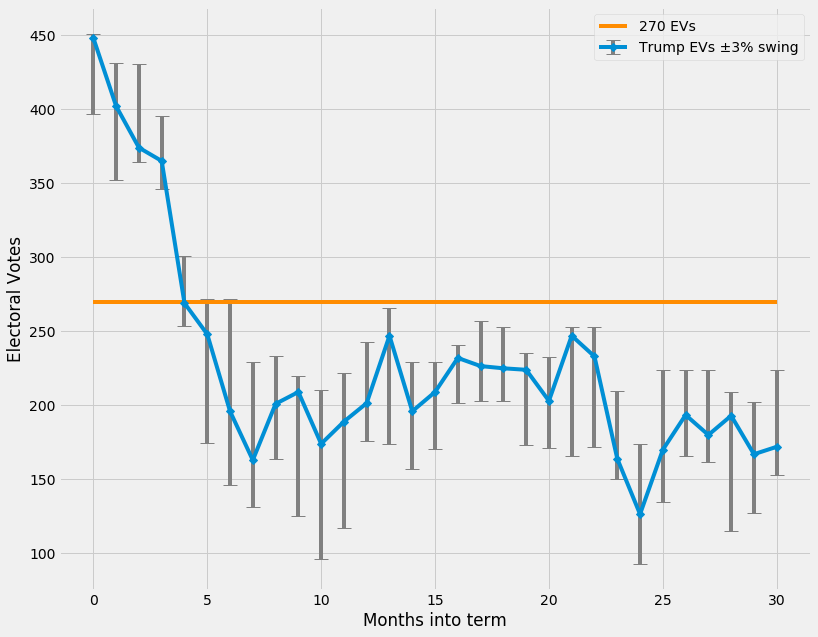

In [8]:
def labels(xlab, ylab): plt.xlabel(xlab); plt.ylabel(ylab); plt.grid(True); plt.legend()
    
plt.rcParams["figure.figsize"] = [12, 10]
plt.style.use('fivethirtyeight')
    
def plot1(states, dates, swing=3):
    N = len(dates)
    err = [[EV(states, date) - EV(states, date, -swing) for date in dates],
           [EV(states, date, swing) - EV(states, date) for date in dates]]
    plt.plot(range(N), [270] * N, color='darkorange', label="270 EVs")
    plt.errorbar(range(N), [EV(states, date) for date in dates], fmt='D-',
                 yerr=err, ecolor='grey', capsize=7, label='Trump EVs ±3% swing')
    labels('Months into term', 'Electoral Votes')
    
plot1(states, dates)

# Margin and country-wide net approval by month

The next plot gives the swing margin needed to reach 270 for each month, along with the country-wide net approval. Trump has been in negative territory on all metrics since his fourth month in office. He's been net -10% or worse every month since his third in office. His necessary margin has been 4% or worse every month since his seventh.  We see that the state-by-state margin roughly correlates with the country-wide net approval, but not exactly.

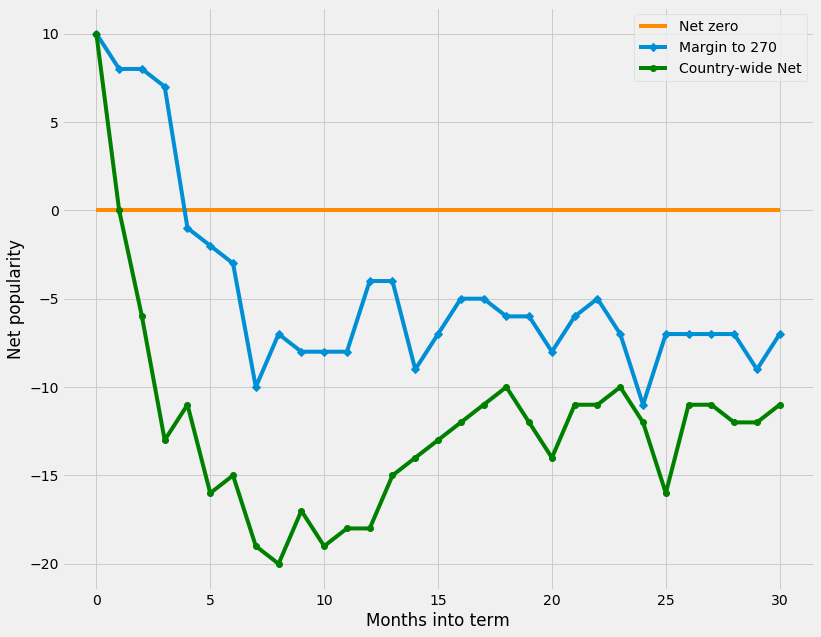

In [9]:
def plot2(states, dates):
    N = len(dates)
    plt.plot(range(N), [0] * N, label='Net zero', color='darkorange')
    plt.plot(range(N), [-margin(states, date) for date in dates], 'D-', label='Margin to 270')
    plt.plot(range(N), [net_usa[date] for date in dates], 'go-', label='Country-wide Net')
    labels('Months into term', 'Net popularity')
    
plot2(states, dates)

# Month-by-month summary table

For each month, we show the expected electoral vote total (**EVs**), the swing margin needed to get to 270 (**Margin**), the overall (popular vote) net approval across the whole country (**Country**), and then the total percentage of undecided voters and in parentheses the number of states with at least 5% undecided.
Note that the country-wide vote is not all that correlated with the state-by-state margin: recently the state-by-state margin has held at 7% while the country-wide net approval has ranged from -10% to -16%, and when the state-by-state margin jumped to 11%, the country-wide measure stayed right in the middle at 12%.

In [10]:
def header(head) -> str: return head + '\n' + '-'.join('|' * head.count('|'))

def markdown(fn) -> callable: return lambda *args: display(Markdown('\n'.join(fn(*args))))

@markdown
def by_month(states, dates=reversed(dates)):
    yield header('|Month|EVs|Margin|Country|Undecided|')
    for date in dates:
        month = date.replace('1-', '').replace('-', ' 20')
        yield (f'|{month}|{int(EV(states, date))}|{margin(states, date)}%|{net_usa[date]}%'
               f'|{sum(s.ev * undecided(s, date) for s in states) / 538:.0f}% '
               f'({sum(undecided(s, date) > 5 for s in states)})|')
        
by_month(states)

|Month|EVs|Margin|Country|Undecided|
|-|-|-|-|-|
|Jul 2019|172|7%|-11%|4% (1)|
|Jun 2019|167|9%|-12%|4% (1)|
|May 2019|193|7%|-12%|4% (1)|
|Apr 2019|180|7%|-11%|4% (0)|
|Mar 2019|193|7%|-11%|4% (2)|
|Feb 2019|170|7%|-16%|4% (0)|
|Jan 2019|126|11%|-12%|4% (0)|
|Dec 2018|164|7%|-10%|5% (3)|
|Nov 2018|233|5%|-11%|4% (1)|
|Oct 2018|247|6%|-11%|4% (3)|
|Sep 2018|203|8%|-14%|4% (1)|
|Aug 2018|224|6%|-12%|4% (0)|
|Jul 2018|225|6%|-10%|4% (1)|
|Jun 2018|226|5%|-11%|4% (0)|
|May 2018|232|5%|-12%|4% (0)|
|Apr 2018|209|7%|-13%|4% (0)|
|Mar 2018|196|9%|-14%|4% (0)|
|Feb 2018|247|4%|-15%|4% (2)|
|Jan 2018|201|4%|-18%|5% (4)|
|Dec 2017|189|8%|-18%|5% (8)|
|Nov 2017|174|8%|-19%|5% (7)|
|Oct 2017|209|8%|-17%|5% (7)|
|Sep 2017|201|7%|-20%|5% (8)|
|Aug 2017|163|10%|-19%|7% (33)|
|Jul 2017|196|3%|-15%|5% (4)|
|Jun 2017|248|2%|-16%|5% (15)|
|May 2017|269|1%|-11%|5% (4)|
|Apr 2017|365|-7%|-13%|4% (4)|
|Mar 2017|374|-8%|-6%|5% (14)|
|Feb 2017|402|-8%|0%|6% (48)|
|Jan 2017|448|-10%|10%|11% (51)|

# State-by-state summary table

Below is each state sorted by net approval, with the state's  maximum expected movement, and electoral vote allotment, followed by the cumulative running total of electoral votes and the percentages of  approval, disapprovals, and undecided in the state, and finally the standard deviation of the net approval over the last 12 months. By going down the **Total** column, you can see what it takes to win. 

The **CAPITALIZED bold state names**  are the **swing states**, which I define as states in which the absolute value of net approval is less than two standard deviations of the net approval over time, plus a fifth of the undecided voters. The idea is that if we are just dealing with random sampling variation, you could expect future approval to be within two standard deviations 95% of the time, and if the undecideds split 60/40, then a candidate could get a net fifth of them. So it would be very unusual for the non-bold states to flip, unless some events change perception of the candidates.

This analysis says that to win, Trump would need to take *all* the swing states,  plus Ohio, Arizona, and Pennsylvannia, which are traditionally considered swing states, but are not under my model because Trump currently trails by a lot (6 0r 7% in each state), and movement there is low. 


In [11]:
@markdown
def by_state(states, d=now):
    total = 0
    yield header('|State|Net|Move|EV|Total|+|-|?|𝝈|')
    for s in sorted(states, key=net, reverse=True):
        total += s.ev
        b = '**' * is_swing(s)
        yield (f'|{swing_name(s)}|{b}{net(s):+d}%{b}|{b}{movement(s):.0f}%{b}|{s.ev}|{total}'
               f'|{s.approvals[d]}%|{s.disapprovals[d]}%|{undecided(s, now)}%|{𝝈(s):3.1f}%|')
        
def swing_name(s) -> str: return ('**' + s.name.upper() + '**') if is_swing(s) else s.name

by_state(states)

|State|Net|Move|EV|Total|+|-|?|𝝈|
|-|-|-|-|-|-|-|-|-|
|Alabama|+26%|7%|9|9|61%|35%|4%|2.9%|
|Mississippi|+23%|8%|6|15|59%|36%|5%|3.5%|
|Wyoming|+21%|11%|3|18|58%|37%|5%|4.9%|
|Tennessee|+20%|7%|11|29|58%|38%|4%|3.0%|
|West Virginia|+18%|10%|5|34|57%|39%|4%|4.8%|
|Idaho|+17%|5%|4|38|57%|40%|3%|2.3%|
|Louisiana|+17%|7%|8|46|56%|39%|5%|3.2%|
|Oklahoma|+16%|8%|7|53|56%|40%|4%|3.5%|
|Kentucky|+15%|3%|8|61|55%|40%|5%|1.1%|
|South Carolina|+11%|5%|9|70|54%|43%|3%|2.3%|
|**SOUTH DAKOTA**|**+10%**|**10%**|3|73|53%|43%|4%|4.7%|
|Arkansas|+9%|7%|6|79|53%|44%|3%|3.2%|
|**MISSOURI**|**+6%**|**7%**|10|89|51%|45%|4%|3.3%|
|**MONTANA**|**+6%**|**7%**|3|92|51%|45%|4%|3.3%|
|Texas|+6%|5%|38|130|51%|45%|4%|2.0%|
|**INDIANA**|**+5%**|**5%**|11|141|51%|46%|3%|2.3%|
|**KANSAS**|**+5%**|**6%**|6|147|51%|46%|3%|2.6%|
|**NORTH DAKOTA**|**+5%**|**7%**|3|150|51%|46%|3%|3.2%|
|**UTAH**|**+3%**|**8%**|6|156|50%|47%|3%|3.6%|
|**GEORGIA**|**+2%**|**6%**|16|172|49%|47%|4%|2.8%|
|**FLORIDA**|**-1%**|**5%**|29|201|48%|49%|3%|2.3%|
|**NEBRASKA**|**-1%**|**7%**|5|206|48%|49%|3%|3.3%|
|**NORTH CAROLINA**|**-1%**|**5%**|15|221|48%|49%|3%|2.3%|
|**ALASKA**|**-2%**|**11%**|3|224|46%|48%|6%|4.8%|
|**VIRGINIA**|**-4%**|**4%**|13|237|46%|50%|4%|1.8%|
|Ohio|-6%|6%|18|255|45%|51%|4%|2.4%|
|Arizona|-7%|7%|11|266|45%|52%|3%|3.1%|
|Pennsylvania|-7%|3%|20|286|45%|52%|3%|1.4%|
|Iowa|-11%|5%|6|292|43%|54%|3%|2.1%|
|Nevada|-11%|6%|6|298|43%|54%|3%|2.8%|
|Colorado|-12%|5%|9|307|43%|55%|2%|2.1%|
|Michigan|-12%|5%|16|323|42%|54%|4%|2.0%|
|Delaware|-13%|6%|3|326|42%|55%|3%|2.5%|
|Maine|-13%|7%|4|330|42%|55%|3%|3.0%|
|New Mexico|-13%|6%|5|335|42%|55%|3%|2.9%|
|Minnesota|-14%|5%|10|345|41%|55%|4%|2.2%|
|Wisconsin|-14%|5%|10|355|41%|55%|4%|2.3%|
|New Jersey|-15%|4%|14|369|41%|56%|3%|1.9%|
|New Hampshire|-17%|9%|4|373|40%|57%|3%|4.4%|
|Illinois|-18%|4%|20|393|39%|57%|4%|1.4%|
|Oregon|-19%|4%|7|400|39%|58%|3%|1.9%|
|Rhode Island|-20%|6%|4|404|38%|58%|4%|2.5%|
|Connecticut|-22%|7%|7|411|37%|59%|4%|3.0%|
|Hawaii|-22%|10%|4|415|38%|60%|2%|4.6%|
|New York|-24%|5%|29|444|36%|60%|4%|1.9%|
|Maryland|-27%|6%|10|454|35%|62%|3%|2.7%|
|Washington|-27%|5%|12|466|35%|62%|3%|2.4%|
|Vermont|-29%|8%|3|469|34%|63%|3%|3.6%|
|California|-30%|5%|55|524|33%|63%|4%|2.0%|
|Massachusetts|-30%|5%|11|535|34%|64%|2%|2.1%|
|District of Columbia|-61%|4%|3|538|18%|79%|3%|1.6%|

# Popularity Above Replacement President (PARP) table

Fivethirtyeight is a combination sports/politics site, and it has a lot of statistics about sports players and how much better they are than the average replacement player. Given that, they [decided](https://fivethirtyeight.com/features/the-states-where-trump-is-more-and-less-popular-than-he-should-be/) to rate the president's approval versus each state's overall approval of his party (in recent elections), which is a way of rating the president's performance versus an average replacement candidate from the same party. I'll duplicate that work and keep it up to date.

There are only five states where Trump is exceeding a replacement Republican (i.e., has a positive PARP): one deep-red southern state, Mississippi, and three deep-blue coastal states, Hawaii, Delaware, and Rhode Island. Again, the swing states are **BOLD CAPITALIZED**.

In [12]:
def parp(state) -> int: return net(state) - state.lean 

@markdown
def by_parp(states, d=now):
    yield header('|State|PARP|Net|Lean|EV|')
    for s in sorted(states, key=parp, reverse=True):
        yield (f'|{swing_name(s)}|{parp(s):+d}|{net(s):+d}|{s.lean:+d}|{s.ev}|')

by_parp(states)

|State|PARP|Net|Lean|EV|
|-|-|-|-|-|
|Hawaii|+14|-22|-36|4|
|Mississippi|+8|+23|+15|6|
|Rhode Island|+6|-20|-26|4|
|Delaware|+1|-13|-14|3|
|Louisiana|+0|+17|+17|8|
|Alabama|-1|+26|+27|9|
|Massachusetts|-1|-30|-29|11|
|New Jersey|-2|-15|-13|14|
|New York|-2|-24|-22|29|
|Maryland|-4|-27|-23|10|
|**VIRGINIA**|-4|-4|+0|13|
|Illinois|-5|-18|-13|20|
|Vermont|-5|-29|-24|3|
|California|-6|-30|-24|55|
|**FLORIDA**|-6|-1|+5|29|
|New Mexico|-6|-13|-7|5|
|**NORTH CAROLINA**|-6|-1|+5|15|
|South Carolina|-6|+11|+17|9|
|Kentucky|-8|+15|+23|8|
|Maine|-8|-13|-5|4|
|Pennsylvania|-8|-7|+1|20|
|Tennessee|-8|+20|+28|11|
|**GEORGIA**|-10|+2|+12|16|
|Oregon|-10|-19|-9|7|
|Colorado|-11|-12|-1|9|
|Connecticut|-11|-22|-11|7|
|Michigan|-11|-12|-1|16|
|Texas|-11|+6|+17|38|
|Minnesota|-12|-14|-2|10|
|**MONTANA**|-12|+6|+18|3|
|Nevada|-12|-11|+1|6|
|West Virginia|-12|+18|+30|5|
|**INDIANA**|-13|+5|+18|11|
|**MISSOURI**|-13|+6|+19|10|
|Ohio|-13|-6|+7|18|
|Arkansas|-15|+9|+24|6|
|Washington|-15|-27|-12|12|
|Wisconsin|-15|-14|+1|10|
|Arizona|-16|-7|+9|11|
|**ALASKA**|-17|-2|+15|3|
|Iowa|-17|-11|+6|6|
|District of Columbia|-18|-61|-43|3|
|Idaho|-18|+17|+35|4|
|**KANSAS**|-18|+5|+23|6|
|Oklahoma|-18|+16|+34|7|
|New Hampshire|-19|-17|+2|4|
|**SOUTH DAKOTA**|-21|+10|+31|3|
|**NEBRASKA**|-25|-1|+24|5|
|Wyoming|-26|+21|+47|3|
|**NORTH DAKOTA**|-28|+5|+33|3|
|**UTAH**|-28|+3|+31|6|